<a href="https://colab.research.google.com/github/stbiadmin/myopia/blob/main/image_degrader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init and Setup

In [25]:
###uncomment install non-collab-native libraries (run once)
#!pip install thispersondoesnotexist
#!pip install ipython ipykernel --upgrade
#!pip install asyncio

## Install GCS packages
#!pip install --q fsspec
#!pip install --q gcsfs

##Install Vectice Python library 
#!pip install --q vectice[github]==2.2.3

#Import the required packages
from vectice import Experiment
from vectice.api.json import ModelType
from vectice.api.json import JobType
from vectice.api.json import JobArtifactType
from vectice.api.json import ModelVersionStatus
from vectice.api.json.artifact_version import VersionStrategy
import logging
import os
logging.basicConfig(level=logging.INFO)


#import libraries
from thispersondoesnotexist import get_online_person, get_checksum_from_picture,save_picture, Person
import skimage as sk
import skimage.io as skio
import skimage.color as color
import numpy as np
import matplotlib.pyplot as plt
import random
import asyncio
import cv2
from scipy import signal
from scipy import misc
from scipy import interpolate
from scipy import ndimage
from skimage.transform import resize
import os

In [14]:
#await requires ipython update, this checks version
import IPython
IPython.version_info

(7, 34, 0, '')

In [24]:
#Verify if Vectice python library was installed
!pip3 show vectice

Name: vectice
Version: 2.2.3
Summary: Vectice Python library
Home-page: https://github.com/vectice/vectice-python
Author: Vectice Inc.
Author-email: sdk@vectice.com
License: Apache License 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: requests, urllib3, python-dotenv
Required-by: 


In [26]:
# Specify the API endpoint for Vectice.
# You can specify your API endpoint here in the notebook, but we recommand you to add it to a .env file
os.environ['VECTICE_API_ENDPOINT']= "app.vectice.com"

# To use the Vectice Python library, you first need to authenticate your account using an API key.
# You can generate an API key from the Vectice UI, by going to the "My API Keys" section under your profile's picture
# You can specify your API Token here in the notebook, but we recommand you to add it to a .env file
os.environ['VECTICE_API_TOKEN'] = "lM56j25kR.lAGBa8yxQEVW2egJvY7ZOlM56j25kRodDNrb9nm0LwX34jpP6z"

# Add you project id. The project id can be found in the project settings page in the Vectice UI
project_id = 5194

In [ ]:
# We create our first experiment for data preparation and specify the workspace and the project we will be working on
# Each experiment only contains one job. Each invokation of the job is called a run.
# autocode = True enables you to track your git changes for your code automatically every time you execute a run (see below).
experiment = Experiment(job="Data Preparation", project=project_id, job_type=JobType.PREPARATION, auto_code=True)

## Helper Functions

In [45]:
def warpit(im,imname, nsynths):
    for i in range(nsynths):
        dim = 256
        j = random.randint(1,50) + 30; # JPEG compression
        b = 3*random.random() #blur
        g = random.random() + 1; # gamma
        w = 4*np.random.randn() # local geometric warping
        n = random.random()/ 8 # additive noise

        gkern_1D = cv2.getGaussianKernel(11,b+np.finfo(float).eps)
        gkern_2D = np.outer(np.transpose(gkern_1D), gkern_1D )

        im_res = resize(im, [dim,dim])
        x = np.array(list(range(0,dim)))
        y = np.array(list(range(0,dim)))
        x1 = np.array(list(range(1,dim,16)))
        y1 = np.array(list(range(1,dim,16)))

        [xramp,yramp] = np.meshgrid(x,y)
        [xramp2,yramp2] = np.meshgrid(x1,y1)

        xramp2 = xramp2 + w*np.random.randn(xramp2.shape[0],xramp2.shape[1])
        yramp2 = yramp2 + w*np.random.randn(yramp2.shape[0],yramp2.shape[1])

        xramp2 = resize(xramp2, [dim, dim])
        yramp2 = resize(yramp2, [dim, dim])

        im2 = im_res

        for z in range(0,3):
            im2[:,:,z] = signal.convolve2d(im2[:,:,z],gkern_2D , mode='same')
            im2[:,:,z] = ndimage.map_coordinates(im2[:,:,z], [yramp2,xramp2], mode='nearest')
            
        im2 = np.sign(255 * (im2/255)) * np.abs(255 * (im2/255))**g #numpy doesn't allow fractional negative numbers..Workaround
        im2 = im2 + n*np.random.randn(xramp2.shape[1],xramp2.shape[0], 3); # additive noise

        im2 = im2 - im2.min()
        im2 = 255 * im2/im2.max() # scale into [0,255]
        
        plt.imsave('temp.jpg', im2.astype('uint8'))
        im2 = cv2.imread('temp.jpg')
        
        num_rows, num_cols = im2.shape[:2]
        center = (num_cols/2, num_rows/2)
        angle = random.randrange(-5,5,1)
        rot_mat = cv2.getRotationMatrix2D(center,angle, scale =1)
        tx, ty = 10*np.random.randn(), 10* np.random.randn()
        t_map = np.array([
            [1, 0, tx],
            [0, 1, ty]
        ], dtype=np.float32)
        im2 = cv2.warpAffine(im2,rot_mat,(num_cols, num_rows))
        im2 = cv2.warpAffine(im2,t_map,(num_cols, num_rows))
        im2 = im2[30: -30,30: -30,:]
        
       
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow(im)
        plt.subplot(1,2,2)
        plt.imsave('/content/faces/TPDNE/Degraded/'+ imname +'_'+str(i)+'.jpg', cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
        plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
        plt.show()
       
    print(imname + " processed!")   
    
    return


## Data Generation and Preparation

In [47]:
# We create our first experiment for data preparation and specify the workspace and the project we will be working on
# Each experiment only contains one job. Each invokation of the job is called a run.
# autocode = True enables you to track your git changes for your code automatically every time you execute a run (see below).
experiment = Experiment(job="Data Generation and Preparation (faces)_2", project=project_id, job_type=JobType.PREPARATION, auto_code=True)

In [48]:
# The Vectice library automatically detects if there have been changes to the dataset you are using.
# If it detects changes, it will generate a new version of your dataset automatically. 
# For this tutorial, we changed the data since Albert left the company.
# So, the Vectice Python library will create a new dataset version when this code is executed for the first time.
experiment.add_dataset_version(dataset="GAN-created Faces + Random Degradation", version_strategy=VersionStrategy.AUTOMATIC)

ArtifactReference(code=None, dataset=GAN-created Faces + Random Degradation, model=None, version_number=None, version_id=None, version_name=None, version_strategy=VersionStrategy.AUTOMATIC, description=None, )

In [29]:
# Because we are using Colab in this tutorial example we are going to declare a reference to the code
## manually. This will be added as a reference to the run we are going to create next.
# If you are using your local environment with GIT installed or JupyterLab etc... the code
# tracking is automated.
input_code = experiment.add_code_version_uri(git_uri="https://github.com/stbiadmin/myopia",
                                             entrypoint="image_degrader.ipynb") 

In [31]:
# The created dataset version and code version will be automatically attached as inputs of the run
experiment.start(run_properties={"NumFaces": "1", "NumSynths": "0"})

Run(id=15915, job=Job(name=Data Generation and Preparation (faces), id=9555, description=None, type=JobType.PREPARATION), name=Run 2022-05-29T02:47:47.872840, system_name=None, start_date=2022-05-29 02:47:49.065347, end_date=None, duration=None, status=RunStatus.STARTED, inputs=[ArtifactReference(code=None, dataset=GAN-created Faces, model=None, version_number=None, version_id=None, version_name=None, version_strategy=VersionStrategy.AUTOMATIC, description=None, ), ArtifactReference(code=1001, dataset=None, model=None, version_number=None, version_id=2571, version_name=None, version_strategy=None, description=None, )], outputs=[])

In [38]:
n = 1 # number of raw fake faces to download
m = 1 #number of synthetic degraded faces to generate
path = '/content/faces/TPDNE/Original/'

In [39]:
for i in range(n):
  # Using function
  picture =  await get_online_person()
  checksum2 = get_checksum_from_picture(picture)  # Method is optional, defaults to "md5"
  await save_picture(picture, path+str(checksum2)+'.jpg')

<function matplotlib.pyplot.show(*args, **kw)>

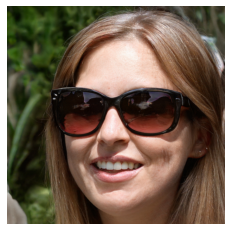

In [40]:
img1 = plt.imread('/content/faces/TPDNE/Original/f7f582c7ac073ebd397fc58a4e074ad2.jpg')
plt.imshow(img1)
plt.axis('off')
plt.show

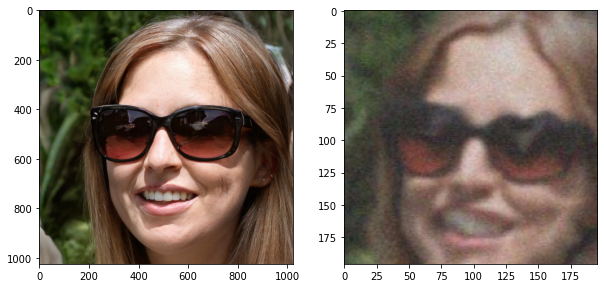

f7f582c7ac073ebd397fc58a4e074ad2 processed!


In [46]:
for filename in os.listdir(path):
    if filename.endswith(".jpg"):
        img = plt.imread(path+filename)
        warpit(img, filename[:-4], m)

In [32]:
experiment.complete()